<a href="https://colab.research.google.com/github/Kapil-Bhardwaj/NextWordPrediction/blob/main/NextWordPredictionModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab Notebooks/Model2

/content/drive/MyDrive/Colab Notebooks/Model2


In [ ]:
!nvidia-smi

Sat Jul 22 16:41:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **1. Import the required librariest**

In [ ]:
# We use TensorFlow with Keras for our model building.
# We can import the LSTM model from Keras and use it.
# For different NLP tasks, we can use the NLTK library.

import numpy as np

import heapq

import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer

from keras.models import Sequential, load_model

from keras.layers.core import Dense, Activation

from keras.layers import LSTM

import pickle

from keras.optimizers import RMSprop

# **2. Read the dataset:**


In [ ]:
path = 'data.txt'
text = open(path).read().lower()
print('length of the corpus is: :', len(text))

length of the corpus is: : 581888


# 3.  Using tokenizers:

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [ ]:
## Getting all unique words
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
len(unique_word_index)

8201

**Feature Engineering:**

In [ ]:
LENGTH_WORD = 5
next_words = []
prev_words = []
for j in range(len(words) - LENGTH_WORD):
     prev_words.append(words[j:j + LENGTH_WORD])
     next_words.append(words[j + LENGTH_WORD])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [ ]:
# Storing Featurs and labels
X = np.zeros((len(prev_words), LENGTH_WORD, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
   for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
   Y[i, unique_word_index[next_words[i]]] = 1

#  Building our model
We can see that we have built an LSTM model and used a softmax activation at the end to get few specific words predicted by the model.

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(LENGTH_WORD, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [ ]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history


Epoch 1/20
811/811 [==============================] - 18s 16ms/step - loss: 5.9981 - acc: 0.1078 - val_loss: 7.1336 - val_acc: 0.1064
Epoch 2/20
811/811 [==============================] - 12s 15ms/step - loss: 5.7759 - acc: 0.1483 - val_loss: 7.9450 - val_acc: 0.0981
Epoch 3/20
811/811 [==============================] - 12s 15ms/step - loss: 5.7408 - acc: 0.1759 - val_loss: 8.0707 - val_acc: 0.1069
Epoch 4/20
811/811 [==============================] - 12s 14ms/step - loss: 5.4526 - acc: 0.2115 - val_loss: 8.0881 - val_acc: 0.0961
Epoch 5/20
811/811 [==============================] - 11s 14ms/step - loss: 5.1456 - acc: 0.2501 - val_loss: 8.5058 - val_acc: 0.0983
Epoch 6/20
811/811 [==============================] - 11s 14ms/step - loss: 4.8719 - acc: 0.2939 - val_loss: 8.3818 - val_acc: 0.0848
Epoch 7/20
811/811 [==============================] - 11s 14ms/step - loss: 4.6171 - acc: 0.3360 - val_loss: 8.5344 - val_acc: 0.0802
Epoch 8/20
811/811 [==============================] - 12s 14ms

In [ ]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))


In [ ]:
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

# Evaluating the model:

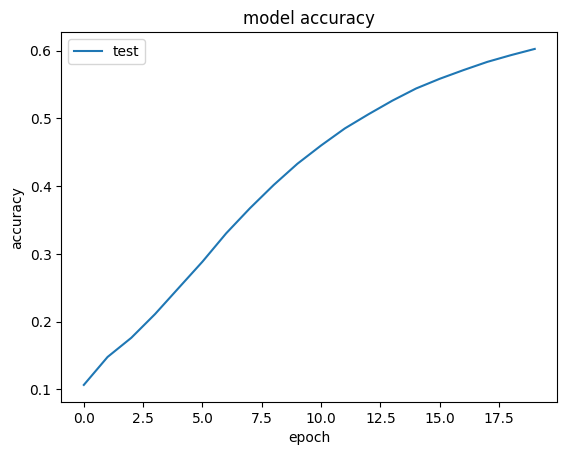

In [ ]:
plt.plot(history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'test'], loc='upper left')

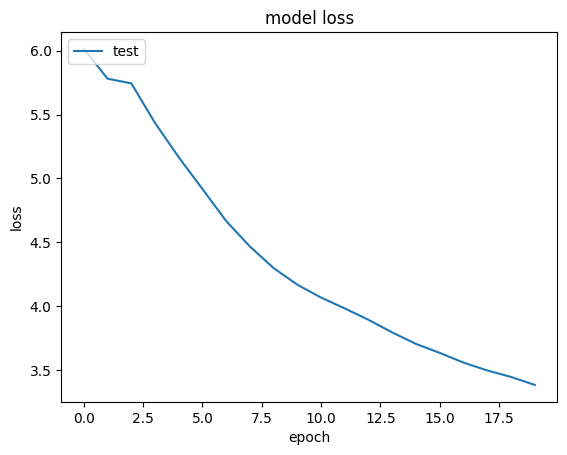

In [ ]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')

## 10. Testing next word

In [ ]:
def prepare_input(text, unique_word_index, LENGTH_WORD):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text.lower())

    prev_words = []
    for j in range(len(words) - LENGTH_WORD):
        prev_words.append(words[j:j + LENGTH_WORD])

    X = np.zeros((len(prev_words), LENGTH_WORD, len(unique_word_index)), dtype=bool)
    for i, each_words in enumerate(prev_words):
        for j, each_word in enumerate(each_words):
            X[i, j, unique_word_index[each_word]] = 1

    return X


In [ ]:
def get_next_word_predictions(text, model, unique_word_index, LENGTH_WORD, top_n=5):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text.lower())

    prev_words = words[-LENGTH_WORD:]
    prepared_input = np.zeros((1, LENGTH_WORD, len(unique_word_index)), dtype=bool)
    for j, each_word in enumerate(prev_words):
      try:
        prepared_input[0, j, unique_word_index[each_word]] = 1
      except Exception as e:
        print("The word is not Present in dictonary", e)
    preds = model.predict(prepared_input, verbose=0)[0]
    next_indices = np.argsort(preds)[-top_n:][::-1]

    next_word_predictions = [list(unique_word_index.keys())[list(unique_word_index.values()).index(idx)] for idx in next_indices]

    return next_word_predictions

quotes = [
    "today I am feeling very "

]
if(len(quotes)==0):
 print("Empty Input")
else:
  for q in quotes:
      seq = q[:40]  # Use the first 40 characters as the initial sequence
      prediction_length = 5  # Number of next-word predictions

      next_word_predictions = get_next_word_predictions(seq, model, unique_word_index, LENGTH_WORD, prediction_length)

      print("Original Quote:", q)

      try:
        print("Next-word Predictions:", next_word_predictions)
      except Exception as e:
        print("An error occurred:", e)

      print()


The word is not Present in dictonary 'today'
Original Quote: today I am feeling very 
Next-word Predictions: ['ordnance', 'produced', 'debt', 'wiser', 'servitude']

